In [6]:
import sys
sys.path.append("/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/code")

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import matplotlib.animation as animation
import scipy as sc
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import package
import torch

## Fonctions utiles

In [3]:
dfc = np.load('/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/inputs.npy')
meta = pd.read_csv("/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/metadata.tsv", sep="\t")
n_runs = len(meta)
n_wins = 464
dfc_train_propofol = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & meta["condition"].isin(['deep-propofol','light-propofol'])].reshape((-1, n_wins, 82, 82))
dfc_test_propofol = dfc[(meta["monkey"] == "jade") & meta["condition"].isin(['deep-propofol','light-propofol'])].reshape((-1, n_wins, 82, 82))
dfc_all = dfc.reshape((-1, n_wins, 82, 82))
dfc_train_background = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana'])].reshape((-1, n_wins, 82, 82))
dfc_test_background = dfc[(meta["monkey"] == "jade")].reshape((-1, n_wins, 82, 82))
conditions_train = meta["condition"][meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & meta["condition"].isin(['deep-propofol','light-propofol'])]
conditions_test = meta["condition"][meta["monkey"].isin(['jade']) & meta["condition"].isin(['deep-propofol','light-propofol'])]
dict_conditions = {"light-propofol":0, "deep-propofol":1}
labels_train = [dict_conditions[elem] for elem in conditions_train]
labels_test = [dict_conditions[elem] for elem in conditions_test]

In [3]:
dfc = np.load('/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/data/DFCs/0.01-0.15-add_compor-False/dfc.npy')
meta = pd.read_csv("/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/data/DFCs/0.01-0.15-add_compor-False/meta.csv")
iu = np.triu_indices(82,k=1)
dfc_flat = dfc[:,:,iu[0],iu[1]]

id_sessions_awake = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "awake"]
id_sessions_light_propofol = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "light-propofol"]
id_sessions_deep_propofol = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "deep-propofol"]
id_sessions_light_sevoflurane = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "sevoflurane2"]
id_sessions_deep_sevoflurane = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "sevoflurane4"]

In [4]:
id_sessions_almira = [i for i in range(len(meta)) if meta["monkey"].iloc[i] == "almira" and meta["condition"].iloc[i] in ["awake","light-propofol","deep-propofol","sevoflurane2","sevoflurane4"]]
id_sessions_jade = [i for i in range(len(meta)) if meta["monkey"].iloc[i] == "jade" and meta["condition"].iloc[i] in ["awake","light-propofol","deep-propofol","sevoflurane2","sevoflurane4"]]
id_sessions_khali = [i for i in range(len(meta)) if meta["monkey"].iloc[i] == "khali" and meta["condition"].iloc[i] in ["awake","light-propofol","deep-propofol","sevoflurane2","sevoflurane4"]]
id_sessions_kimiko = [i for i in range(len(meta)) if meta["monkey"].iloc[i] == "kimiko" and meta["condition"].iloc[i] in ["awake","light-propofol","deep-propofol","sevoflurane2","sevoflurane4"]]
id_sessions_rana = [i for i in range(len(meta)) if meta["monkey"].iloc[i] == "rana" and meta["condition"].iloc[i] in ["awake","light-propofol","deep-propofol","sevoflurane2","sevoflurane4"]]

## PCA on awake-sevoflurane dataset

In [37]:
import importlib
importlib.reload(package.torch_classifier)

<module 'package.torch_classifier' from '/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/code/package/torch_classifier.py'>

In [15]:
id_sessions_sevoflurane = np.concatenate([id_sessions_light_sevoflurane,id_sessions_deep_sevoflurane]).astype(int)
id_sessions_awake_anesthesia = np.concatenate([id_sessions_awake,id_sessions_light_sevoflurane,id_sessions_deep_sevoflurane]).astype(int)
id_sessions_awake_propofol = np.concatenate([id_sessions_awake,id_sessions_light_propofol,id_sessions_deep_propofol]).astype(int)
X = dfc_flat[id_sessions_awake_anesthesia,:,:].reshape(-1,3321)
y = np.array([0]*461* len(id_sessions_awake) + [1]*461*len(id_sessions_light_sevoflurane) + [2]*461*len(id_sessions_deep_sevoflurane))
X_propofol = dfc_flat[id_sessions_awake_propofol,:,:].reshape(-1,3321)
#X_sevoflurane = dfc_flat[id_sessions_awake_sevoflurane,:,:].reshape(-1,3321)
X_almira = dfc_flat[id_sessions_almira,:,:].reshape(-1,3321)
X_jade = dfc_flat[id_sessions_jade,:,:].reshape(-1,3321)
X_khali = dfc_flat[id_sessions_khali,:,:].reshape(-1,3321)
X_kimiko = dfc_flat[id_sessions_kimiko,:,:].reshape(-1,3321)
X_rana = dfc_flat[id_sessions_rana,:,:].reshape(-1,3321)

In [23]:
x = torch.zeros(1)

In [26]:
torch.isin(x,torch.Tensor([0,1]))

tensor([True])

In [42]:
net = package.torch_classifier.MLP(input_dim = 3321)
train = package.torch_classifier.SimpleDataset(X,y)
balanced_batch_sampler = package.torch_classifier.BalancedBatchSampler(train, n_classes = 3, n_samples = 100)
train_loader = torch.utils.data.DataLoader(train, batch_sampler = balanced_batch_sampler)

def criterion(x,target):
    my_batch_size = x.size()[0]       
    return (x.pow(2).sum(dim=1) * torch.isin(target,torch.Tensor([0,2])) - x.pow(2).sum(dim=1) * torch.isin(target,torch.Tensor([1]))).sum()

In [43]:
package.torch_classifier.Train(net,train_loader,None,10,lr = 0.01,criterion=criterion)

tensor(1929.5374, grad_fn=<SumBackward0>)
tensor(1976.1331, grad_fn=<SumBackward0>)
tensor(949250.9375, grad_fn=<SumBackward0>)
tensor(1.2708e+12, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
t

KeyboardInterrupt: 

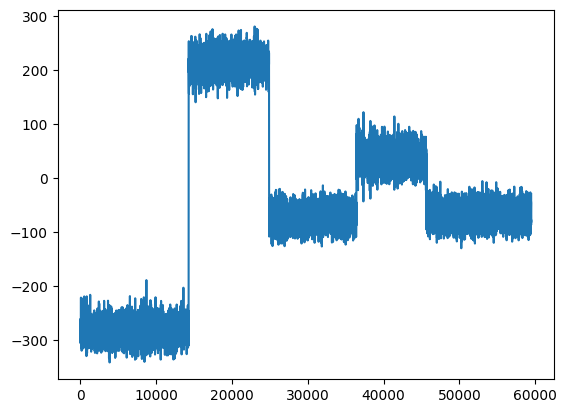

In [158]:
X_pred = X.dot(v)
plt.plot(X_pred[:,1])

In [136]:
y.shape

(59469,)

In [137]:
pca = PCA(n_components=500)
X_reduced = pca.fit_transform(X)
v = pca.components_.T
clf = LinearDiscriminantAnalysis()
X_pred = clf.fit_transform(X_reduced, y)
u = clf.coef_.T
X_anesthesia_reduced = X.dot(v).dot(u)
X_propofol_reduced = X_propofol.dot(v).dot(u)
X_almira_reduced = X_almira.dot(v).dot(u)
X_jade_reduced = X_jade.dot(v).dot(u)
X_khali_reduced = X_khali.dot(v).dot(u)
X_kimiko_reduced = X_kimiko.dot(v).dot(u)
X_rana_reduced = X_rana.dot(v).dot(u)

In [32]:
X_sevoflurane_reduced.shape

(34114, 1)

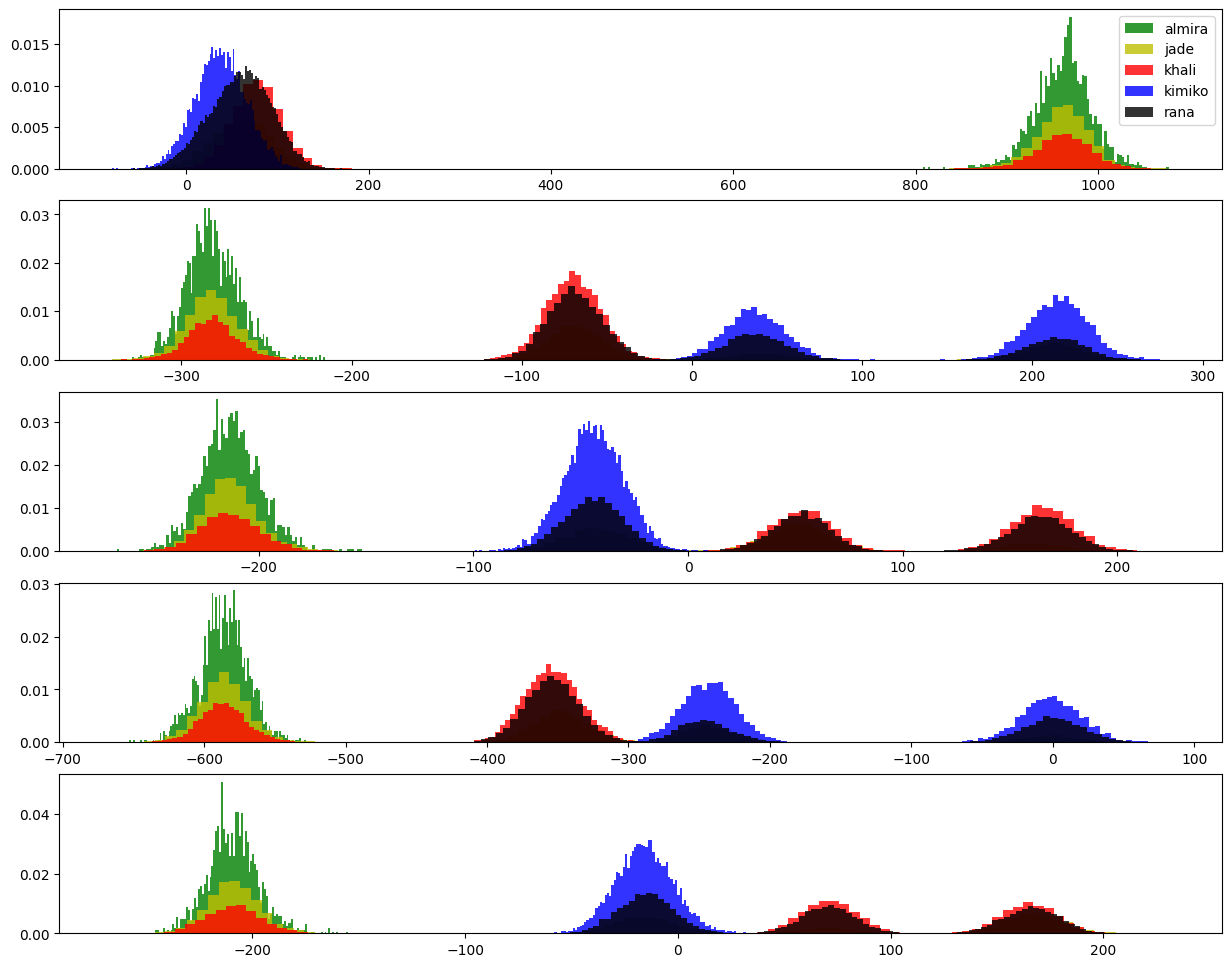

In [155]:
a = len(id_sessions_awake)
b = len(id_sessions_light_sevoflurane)
c = len(id_sessions_light_propofol)
d = len(id_sessions_deep_sevoflurane)
e = len(id_sessions_deep_propofol)

compteur = 0
bins = np.linspace(-10,10,100)

fig = plt.figure(figsize=(15,12))

for i in range(5):
    fig.add_subplot(5,1, i+1)

    v_min = np.min(X_almira_reduced[:,i])
    v_max = np.max(X_almira_reduced[:,i])
    bins = np.linspace(v_min,v_max,100)
    counts_almira,_ = np.histogram(X_almira_reduced[:,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_almira,density = True,label="almira",color="g",alpha=0.8)

    v_min = np.min(X_jade_reduced[:,i])
    v_max = np.max(X_jade_reduced[:,i])
    bins = np.linspace(v_min,v_max,100)
    counts_jade,_ = np.histogram(X_jade_reduced[:,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_jade,density = True,label="jade",color="y",alpha=0.8)

    v_min = np.min(X_khali_reduced[:,i])
    v_max = np.max(X_khali_reduced[:,i])
    bins = np.linspace(v_min,v_max,100)
    counts_khali,_ = np.histogram(X_khali_reduced[:,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_khali,density = True,label="khali",color="r",alpha=0.8)

    v_min = np.min(X_kimiko_reduced[:,i])
    v_max = np.max(X_kimiko_reduced[:,i])
    bins = np.linspace(v_min,v_max,100)
    counts_kimiko,_ = np.histogram(X_kimiko_reduced[:,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_kimiko,density = True,label="kimiko",color="b",alpha=0.8)

    v_min = np.min(X_rana_reduced[:,i])
    v_max = np.max(X_rana_reduced[:,i])
    bins = np.linspace(v_min,v_max,100)
    counts_rana,_ = np.histogram(X_rana_reduced[:,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_rana,density = True,label="rana",color="k",alpha=0.8)
    if i == 0:
        plt.legend()
    compteur += 1 
#plt.text(-40, 0.7, '$\\alpha = 2$', fontsize=22, bbox=dict(facecolor='red', alpha=0.5))
plt.show()

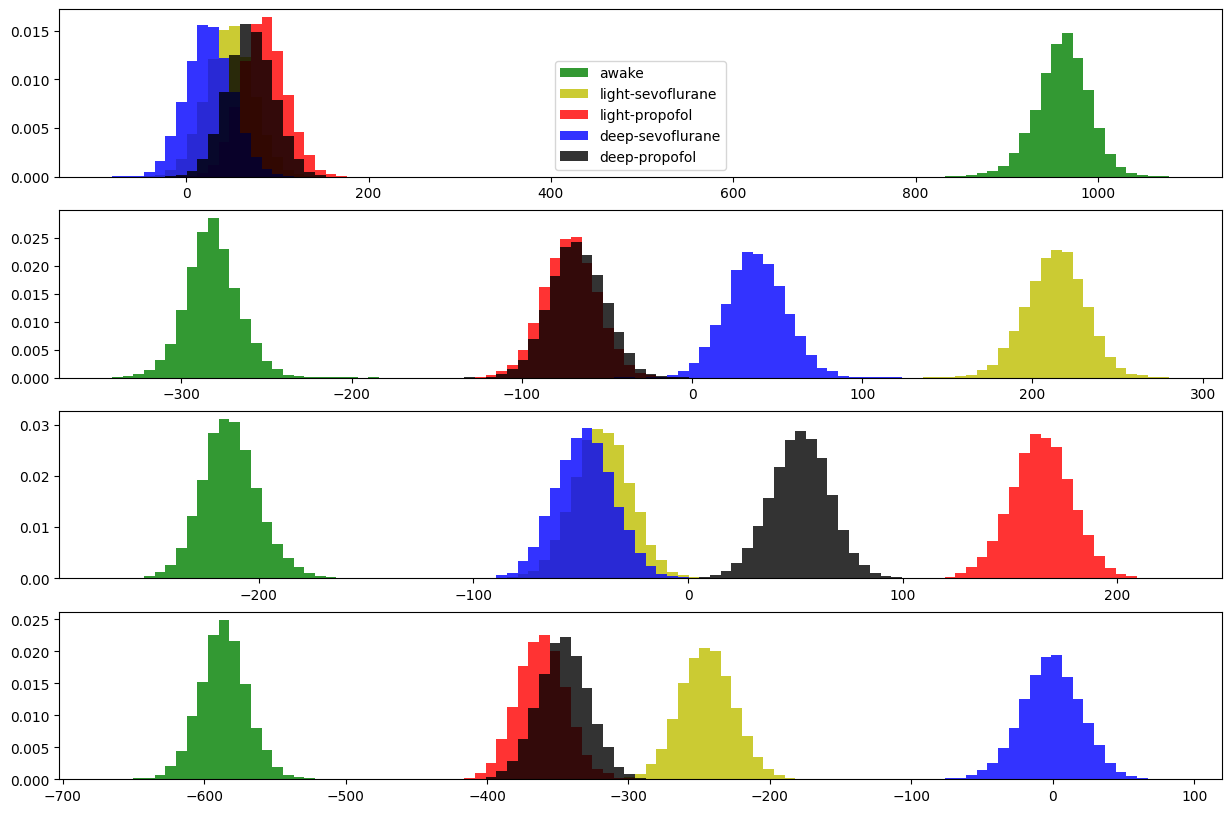

In [159]:
a = len(id_sessions_awake)
b = len(id_sessions_light_sevoflurane)
c = len(id_sessions_light_propofol)
d = len(id_sessions_deep_sevoflurane)
e = len(id_sessions_deep_propofol)

compteur = 0
bins = np.linspace(-10,10,100)

fig = plt.figure(figsize=(15,10))

for i in range(4):
    fig.add_subplot(4,1, i+1)

    v_min = np.min(X_pred[:,i])
    v_max = np.max(X_pred[:,i])
    bins = np.linspace(v_min,v_max,100)

    counts_awake,_ = np.histogram(X_pred[:a*461,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_awake,density = True,label="awake",color="g",alpha=0.8)

    counts_light_sevoflurane,_ = np.histogram(X_pred[a*461:(a+b)*461,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_light_sevoflurane,density = True,label="light-sevoflurane",color="y",alpha=0.8)

    counts_light_propofol,_ = np.histogram(X_pred[(a+b)*461:(a+b+c)*461,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_light_propofol,density = True,label="light-propofol",color="r",alpha=0.8)

    counts_deep_sevoflurane,_ = np.histogram(X_pred[(a+b+c)*461:(a+b+c+d)*461,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_deep_sevoflurane,density = True,label="deep-sevoflurane",color="b",alpha=0.8)

    counts_deep_propofol,_ = np.histogram(X_pred[(a+b+c+d)*461:,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_deep_propofol,density = True,label="deep-propofol",color="k",alpha=0.8)
    
    if i == 0:
        plt.legend()
    compteur += 1 
#plt.text(-40, 0.7, '$\\alpha = 2$', fontsize=22, bbox=dict(facecolor='red', alpha=0.5))
plt.show()

In [43]:
print(meta["condition"][meta["monkey"] == "almira"].unique())
print(meta["condition"][meta["monkey"] == "jade"].unique())
print(meta["condition"][meta["monkey"] == "khali"].unique())
print(meta["condition"][meta["monkey"] == "kimiko"].unique())
print(meta["condition"][meta["monkey"] == "rana"].unique())

['awake']
['awake' 'light-propofol' 'deep-propofol' 'sevoflurane2' 'sevoflurane4']
['awake' 'ketamine' 'light-propofol' 'deep-propofol']
['ketamine' 'sevoflurane2' 'sevoflurane4']
['ketamine' 'light-propofol' 'deep-propofol' 'sevoflurane2' 'sevoflurane4']


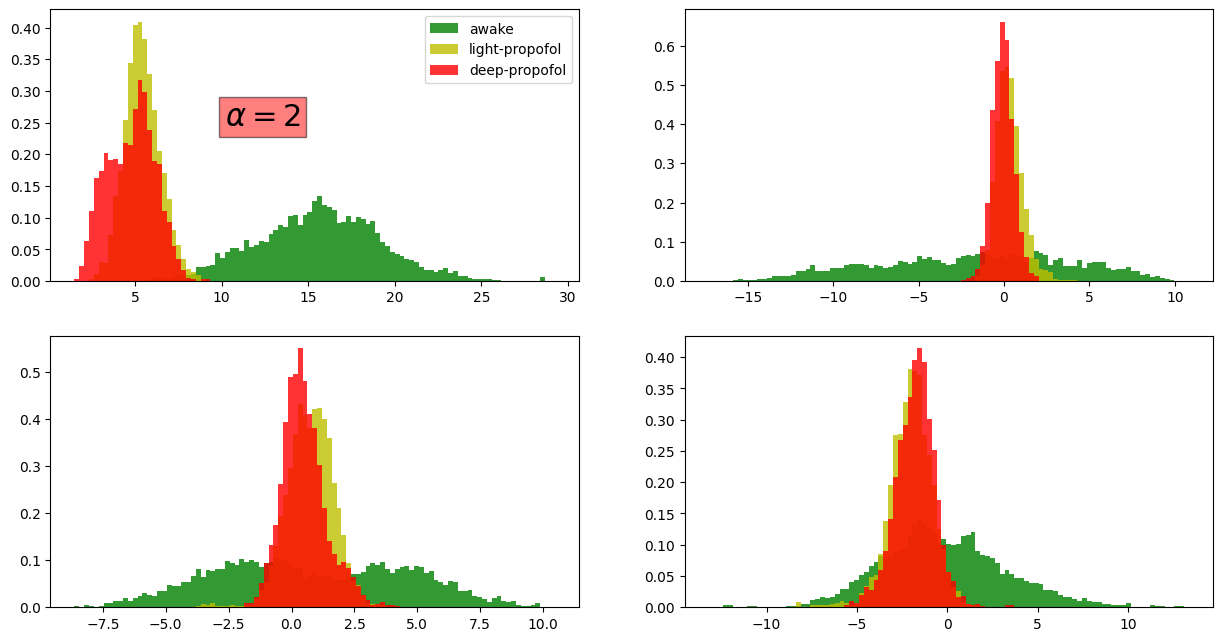

In [57]:
compteur = 0
bins = np.linspace(-10,10,100)

k = len(id_sessions_awake)
n = len(id_sessions_light_propofol)
m = len(id_sessions_deep_propofol)

fig = plt.figure(figsize=(15,12))

for i in range(4):
    v_min = np.min(dfc_propofol_reduced[:,i])
    v_max = np.max(dfc_propofol_reduced[:,i])
    bins = np.linspace(v_min,v_max,100)
    counts_awake,_ = np.histogram(dfc_propofol_reduced[:k*461,i].flatten(),bins)
    counts_light_propofol,_ = np.histogram(dfc_propofol_reduced[k*461:(n+k)*461,i].flatten(),bins)
    counts_deep_propofol,_ = np.histogram(dfc_propofol_reduced[(n+k)*461:,i].flatten(),bins)
    fig.add_subplot(3, 2, i+1)
    plt.hist(bins[:-1], bins, weights=counts_awake,density = True,label="awake",color="g",alpha=0.8)
    plt.hist(bins[:-1], bins, weights=counts_light_propofol,density = True,label="light-propofol",color="y",alpha=0.8)
    plt.hist(bins[:-1], bins, weights=counts_deep_propofol,density = True,label="deep-propofol",color="r",alpha=0.8)
    if i == 0:
        plt.legend()
    compteur += 1 
plt.text(-40, 0.77, '$\\alpha = 2$', fontsize=22, bbox=dict(facecolor='red', alpha=0.5))
plt.show()

In [152]:
v.shape

(3321, 5)

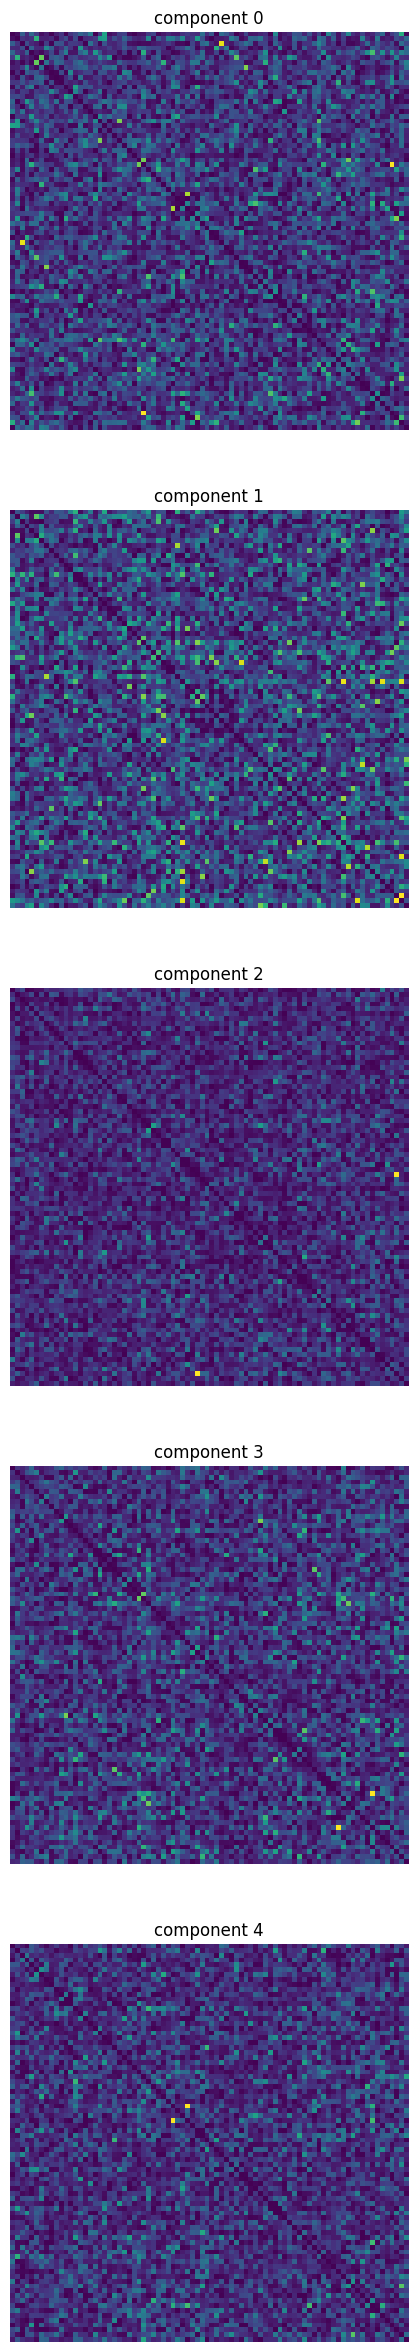

In [160]:
fig = plt.figure(figsize=(30,30))
n = 82
for i in range(5):
    im = np.zeros((n,n))
    iu = np.triu_indices(n,k=1)
    il = np.tril_indices(n,k=-1)
    im[iu[0],iu[1]] = np.abs(v[:,i])
    im = np.transpose(im)
    im[iu[0],iu[1]] = np.abs(v[:,i])
    fig.add_subplot(5,1,i+1)
    plt.imshow(im)
    plt.axis("off")
    plt.title(label="component {}".format(i))
plt.show()

## Essai avec un train/test split

In [161]:
id_sessions_awake_train = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "awake" and meta["monkey"].iloc[i] in ["almira","khali","kimiko","rana"]]
id_sessions_light_propofol_train = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "light-propofol" and meta["monkey"].iloc[i] in ["almira","khali","kimiko","rana"]]
id_sessions_deep_propofol_train = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "deep-propofol" and meta["monkey"].iloc[i] in ["almira","khali","kimiko","rana"]]
id_sessions_light_sevoflurane_train = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "sevoflurane2" and meta["monkey"].iloc[i] in ["almira","khali","kimiko","rana"]]
id_sessions_deep_sevoflurane_train = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "sevoflurane4" and meta["monkey"].iloc[i] in ["almira","khali","kimiko","rana"]]

id_sessions_awake_test = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "awake" and meta["monkey"].iloc[i] in ["jade"]]
id_sessions_light_propofol_test = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "light-propofol" and meta["monkey"].iloc[i] in ["jade"]]
id_sessions_deep_propofol_test = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "deep-propofol" and meta["monkey"].iloc[i] in ["jade"]]
id_sessions_light_sevoflurane_test = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "sevoflurane2" and meta["monkey"].iloc[i] in ["jade"]]
id_sessions_deep_sevoflurane_test = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "sevoflurane4" and meta["monkey"].iloc[i] in ["jade"]]

In [166]:
id_sessions_awake_anesthesia_train = np.concatenate([id_sessions_awake_train,id_sessions_light_sevoflurane_train,id_sessions_light_propofol_train,id_sessions_deep_sevoflurane_train,id_sessions_deep_propofol_train]).astype(int)
id_sessions_awake_anesthesia_test = np.concatenate([id_sessions_awake_test,id_sessions_light_sevoflurane_test,id_sessions_light_propofol_test,id_sessions_deep_sevoflurane_test,id_sessions_deep_propofol_test]).astype(int)
X_train = dfc_flat[id_sessions_awake_anesthesia_train,:,:].reshape(-1,3321)
X_test = dfc_flat[id_sessions_awake_anesthesia_test,:,:].reshape(-1,3321)
y_train = np.array([0]*461* len(id_sessions_awake_train) + [1]*461*len(id_sessions_light_sevoflurane_train) + [2]*461*len(id_sessions_light_propofol_train) + [3]*461*len(id_sessions_deep_sevoflurane_train) + [4]*461*len(id_sessions_deep_propofol_train))
#X_sevoflurane = dfc_flat[id_sessions_awake_sevoflurane,:,:].reshape(-1,3321)
X_almira = dfc_flat[id_sessions_almira,:,:].reshape(-1,3321)
X_jade = dfc_flat[id_sessions_jade,:,:].reshape(-1,3321)
X_khali = dfc_flat[id_sessions_khali,:,:].reshape(-1,3321)
X_kimiko = dfc_flat[id_sessions_kimiko,:,:].reshape(-1,3321)
X_rana = dfc_flat[id_sessions_rana,:,:].reshape(-1,3321)

In [168]:
clf = LinearDiscriminantAnalysis()
X_pred = clf.fit_transform(X_train, y_train)
v = clf.coef_.T
X_test_reduced = X_test.dot(v)
X_almira_reduced = X_almira.dot(v)
X_jade_reduced = X_jade.dot(v)
X_khali_reduced = X_khali.dot(v)
X_kimiko_reduced = X_kimiko.dot(v)
X_rana_reduced = X_rana.dot(v)

In [172]:
X_pred = X_train.dot(v)

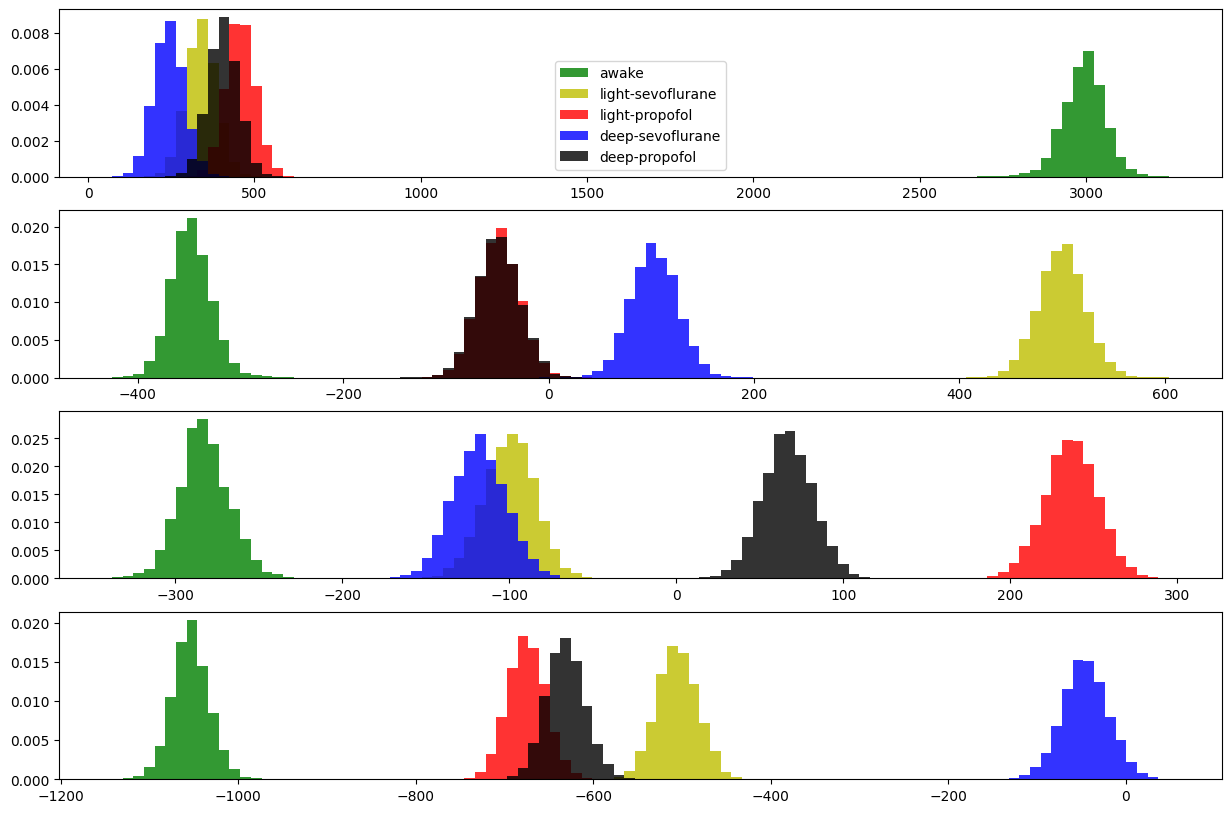

In [173]:
a = len(id_sessions_awake_train)
b = len(id_sessions_light_sevoflurane_train)
c = len(id_sessions_light_propofol_train)
d = len(id_sessions_deep_sevoflurane_train)
e = len(id_sessions_deep_propofol_train)

compteur = 0
bins = np.linspace(-10,10,100)

fig = plt.figure(figsize=(15,10))

for i in range(4):
    fig.add_subplot(4,1, i+1)

    v_min = np.min(X_pred[:,i])
    v_max = np.max(X_pred[:,i])
    bins = np.linspace(v_min,v_max,100)

    counts_awake,_ = np.histogram(X_pred[:a*461,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_awake,density = True,label="awake",color="g",alpha=0.8)

    counts_light_sevoflurane,_ = np.histogram(X_pred[a*461:(a+b)*461,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_light_sevoflurane,density = True,label="light-sevoflurane",color="y",alpha=0.8)

    counts_light_propofol,_ = np.histogram(X_pred[(a+b)*461:(a+b+c)*461,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_light_propofol,density = True,label="light-propofol",color="r",alpha=0.8)

    counts_deep_sevoflurane,_ = np.histogram(X_pred[(a+b+c)*461:(a+b+c+d)*461,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_deep_sevoflurane,density = True,label="deep-sevoflurane",color="b",alpha=0.8)

    counts_deep_propofol,_ = np.histogram(X_pred[(a+b+c+d)*461:,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_deep_propofol,density = True,label="deep-propofol",color="k",alpha=0.8)
    
    if i == 0:
        plt.legend()
    compteur += 1 
#plt.text(-40, 0.7, '$\\alpha = 2$', fontsize=22, bbox=dict(facecolor='red', alpha=0.5))
plt.show()

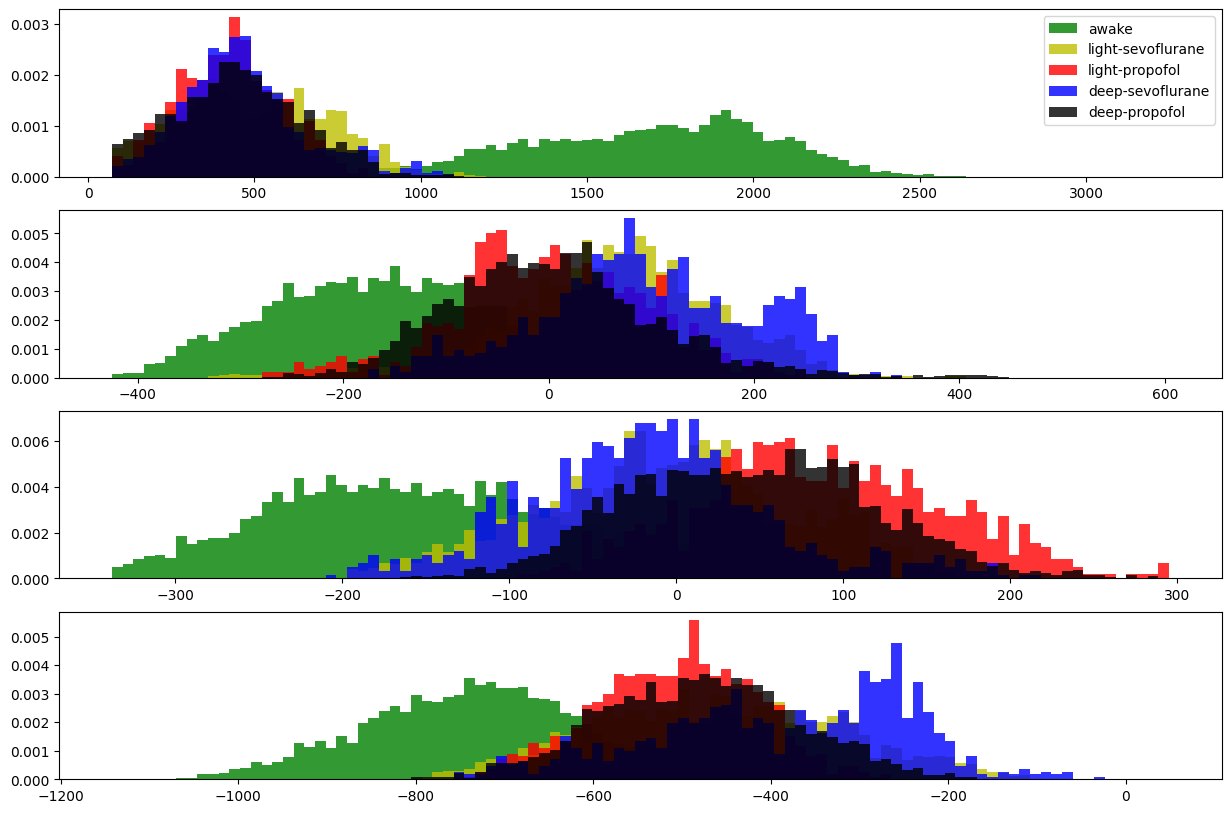

In [174]:
a = len(id_sessions_awake_test)
b = len(id_sessions_light_sevoflurane_test)
c = len(id_sessions_light_propofol_test)
d = len(id_sessions_deep_sevoflurane_test)
e = len(id_sessions_deep_propofol_test)

compteur = 0
bins = np.linspace(-10,10,100)

fig = plt.figure(figsize=(15,10))

for i in range(4):
    fig.add_subplot(4,1, i+1)

    v_min = np.min(X_pred[:,i])
    v_max = np.max(X_pred[:,i])
    bins = np.linspace(v_min,v_max,100)

    counts_awake,_ = np.histogram(X_test_reduced[:a*461,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_awake,density = True,label="awake",color="g",alpha=0.8)

    counts_light_sevoflurane,_ = np.histogram(X_test_reduced[a*461:(a+b)*461,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_light_sevoflurane,density = True,label="light-sevoflurane",color="y",alpha=0.8)

    counts_light_propofol,_ = np.histogram(X_test_reduced[(a+b)*461:(a+b+c)*461,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_light_propofol,density = True,label="light-propofol",color="r",alpha=0.8)

    counts_deep_sevoflurane,_ = np.histogram(X_test_reduced[(a+b+c)*461:(a+b+c+d)*461,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_deep_sevoflurane,density = True,label="deep-sevoflurane",color="b",alpha=0.8)

    counts_deep_propofol,_ = np.histogram(X_test_reduced[(a+b+c+d)*461:,i].flatten(),bins)
    plt.hist(bins[:-1], bins, weights=counts_deep_propofol,density = True,label="deep-propofol",color="k",alpha=0.8)
    
    if i == 0:
        plt.legend()
    compteur += 1 
#plt.text(-40, 0.7, '$\\alpha = 2$', fontsize=22, bbox=dict(facecolor='red', alpha=0.5))
plt.show()